<a href="https://colab.research.google.com/github/ZygoOoade/Similarity-Spaces/blob/main/Mammals_Space_Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 10.6 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

In [ ]:
PROJECT_ID = "gen-lang-client-0284944278"  # @param {type:"string"}
LOCATION = "europe-west8"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
from vertexai.generative_models import GenerationConfig, GenerativeModel, Image, Part

In [ ]:
model = GenerativeModel("gemini-1.5-pro")

In [ ]:
import csv
from itertools import combinations
import time
import re

# Update the generation config
generation_config = GenerationConfig(
    temperature=0.1,
    top_p=1.0,
    top_k=32,
    candidate_count=1,
    max_output_tokens=3,
)

animals = ["camel", "cat", "chimpanzee", "cow", "dog", "donkey", "fox", "giraffe", "goat", "gorilla", "horse", "lion", "mouse", "pig", "rabbit", "rat", "sheep", "tiger", "wolf", "zebra", "monkey", "leopard", "bear", "antelope", "deer", "elephant"]

# Initialize the matrix with zeros
matrix = [[0 for _ in range(26)] for _ in range(26)]

# Set diagonal elements to 100
for i in range(26):
    matrix[i][i] = 100

# Rate limiting parameters
requests_per_second = 1
max_requests_per_minute = 5

# Initialize timing variables
start_time = time.time()
request_times = []

def wait_for_rate_limit():
    current_time = time.time()

    # Remove request times older than 1 minute
    request_times[:] = [t for t in request_times if current_time - t < 60]

    # Check and wait for per-minute limit
    if len(request_times) >= max_requests_per_minute:
        sleep_time = 60 - (current_time - request_times[0])
        if sleep_time > 0:
            time.sleep(sleep_time)

    # Check and wait for per-second limit
    if request_times and current_time - request_times[-1] < 1/requests_per_second:
        time.sleep(1/requests_per_second - (current_time - request_times[-1]))

    # Add current request time
    request_times.append(time.time())

def clean_score(raw_score):
    # Remove leading/trailing whitespace
    cleaned = raw_score.strip()

    # Check if the output begins with two numerical values
    match = re.match(r'^\d{2}', cleaned)
    if match:
        return match.group()

    # Check if the score is in the format "## XX"
    match = re.match(r'^##\s*(\d{1,2})$', cleaned)
    if match:
        return match.group(1)

    # Check if the score is already a number
    if cleaned.isdigit():
        return cleaned

    # If it's none of the above formats, return None
    return None

# Generate similarity scores for all unique pairs
for idx, ((i, animal1), (j, animal2)) in enumerate(combinations(enumerate(animals), 2)):
    prompt = f"Give a score between 0 and 100 that best reflects the degree of similarity between the {animal1} and the {animal2}. Answer only the value of the note."

    # Apply rate limiting
    wait_for_rate_limit()

    responses = model.generate_content(
        prompt,
        generation_config=generation_config,
        stream=True,
    )

    raw_score = ""
    for response in responses:
        raw_score += response.text

    # Clean and convert score to integer
    cleaned_score = clean_score(raw_score)
    if cleaned_score is not None:
        try:
            score = int(cleaned_score)
            if 0 <= score <= 100:
                matrix[i][j] = score
                matrix[j][i] = score
            else:
                print(f"Score out of range for {animal1} and {animal2}: {score}")
        except ValueError:
            print(f"Error converting score for {animal1} and {animal2}: {cleaned_score}")
    else:
        print(f"Unexpected format for {animal1} and {animal2}: {raw_score}")

    print(f"Processed pair {idx+1}/325: {animal1} - {animal2}")

# Write the matrix to a CSV file
with open('similarity_matrix.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([''] + animals)  # Write header row
    for i, row in enumerate(matrix):
        writer.writerow([animals[i]] + row)

print("Matrix has been written to similarity_matrix.csv")
print(f"Total time: {time.time() - start_time:.2f} seconds")

Processed pair 1/325: camel - cat
Processed pair 2/325: camel - chimpanzee
Processed pair 3/325: camel - cow
Processed pair 4/325: camel - dog
Processed pair 5/325: camel - donkey
Processed pair 6/325: camel - fox
Processed pair 7/325: camel - giraffe
Processed pair 8/325: camel - goat
Processed pair 9/325: camel - gorilla
Processed pair 10/325: camel - horse
Processed pair 11/325: camel - lion
Processed pair 12/325: camel - mouse
Processed pair 13/325: camel - pig
Processed pair 14/325: camel - rabbit
Processed pair 15/325: camel - rat
Processed pair 16/325: camel - sheep
Processed pair 17/325: camel - tiger
Processed pair 18/325: camel - wolf
Processed pair 19/325: camel - zebra
Processed pair 20/325: camel - monkey
Processed pair 21/325: camel - leopard
Processed pair 22/325: camel - bear
Processed pair 23/325: camel - antelope
Processed pair 24/325: camel - deer
Processed pair 25/325: camel - elephant
Processed pair 26/325: cat - chimpanzee
Processed pair 27/325: cat - cow
Processe

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


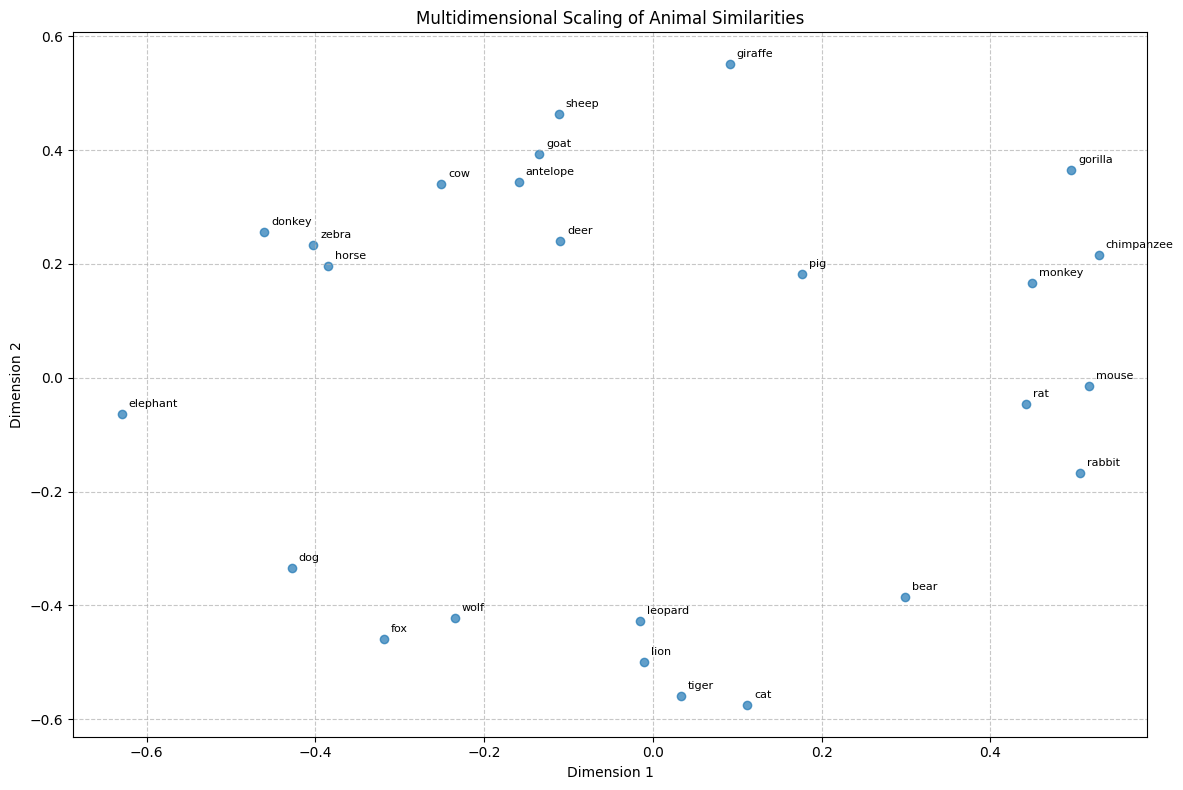

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('similarity_matrix.csv', index_col=0)

# Extract the similarity matrix (excluding the first row and column)
similarity_matrix = df.iloc[1:, 1:].astype(float).values

# Ensure symmetry by averaging with the transpose
similarity_matrix = (similarity_matrix + similarity_matrix.T) / 2

# Convert similarity to dissimilarity
dissimilarity_matrix = 1 - (similarity_matrix / 100)

# Ensure the diagonal is zero (maximum similarity should be zero dissimilarity)
np.fill_diagonal(dissimilarity_matrix, 0)

# Apply MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coordinates = mds.fit_transform(dissimilarity_matrix)

# Extract labels (animal names)
labels = df.columns[1:].tolist()

# Create the plot
plt.figure(figsize=(12, 8))
plt.scatter(coordinates[:, 0], coordinates[:, 1], alpha=0.7)

# Add labels for each point
for i, label in enumerate(labels):
    plt.annotate(label, (coordinates[i, 0], coordinates[i, 1]), xytext=(5, 5),
                 textcoords='offset points', fontsize=8)

plt.title('Multidimensional Scaling of Animal Similarities')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# Show the plot
plt.show()

<ipython-input-11-410bc4bb90e5>:23: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dissimilarity_matrix, method='ward')


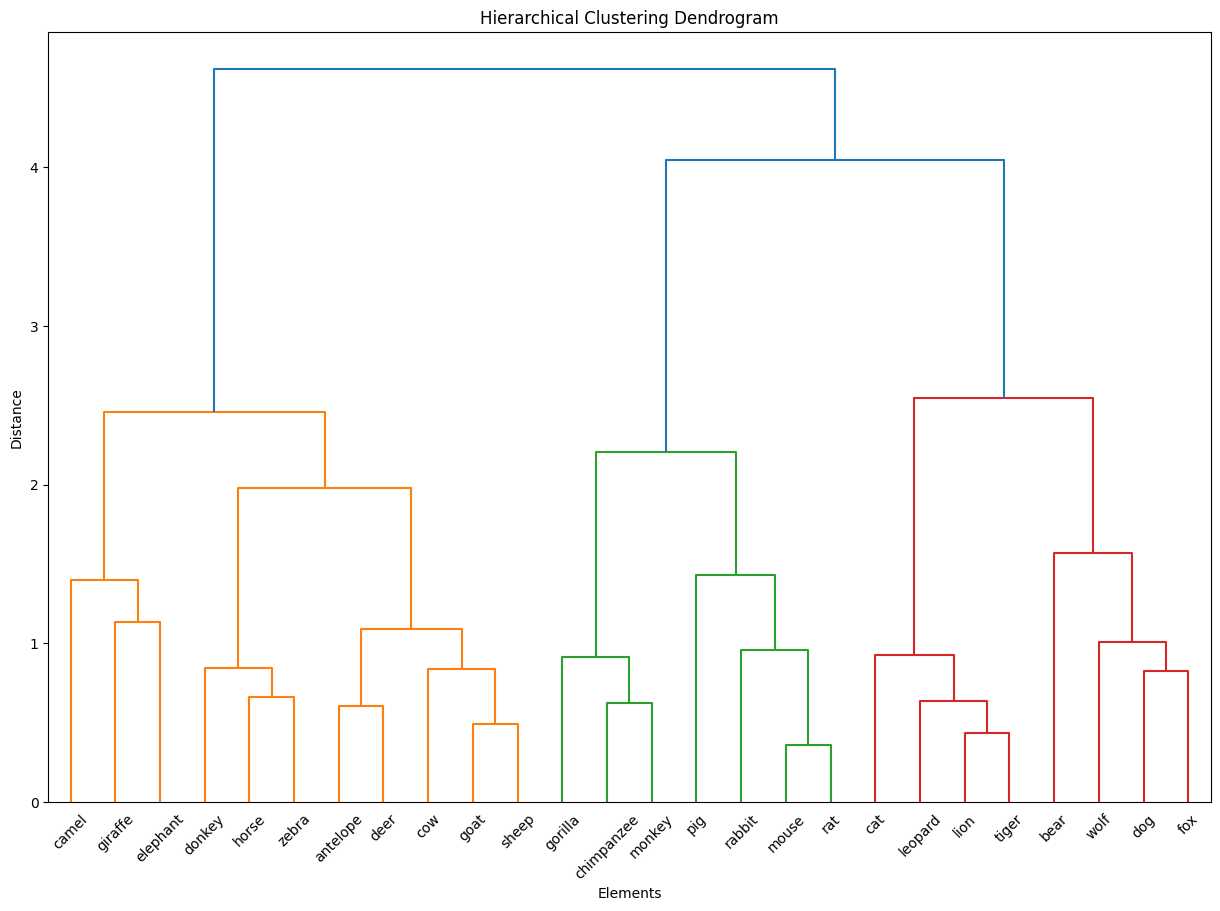

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# Load the similarity matrix CSV file
file_path = 'similarity_matrix.csv'
similarity_df = pd.read_csv(file_path, index_col=0)

# Extract the labels (element names) from the DataFrame
labels = similarity_df.columns.tolist()

# Convert the DataFrame to a NumPy array
similarity_matrix = similarity_df.values

# Convert similarity matrix to dissimilarity matrix
dissimilarity_matrix = 1 - (similarity_matrix / 100)

# Ensure the dissimilarity matrix is symmetric
dissimilarity_matrix = (dissimilarity_matrix + dissimilarity_matrix.T) / 2

# Perform hierarchical clustering
linked = linkage(dissimilarity_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linked, labels=labels, orientation='top', distance_sort='ascending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Elements')
plt.ylabel('Distance')
plt.show()
